# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                     
Sample_148  Q14766                                16.007
Sample_038  A0A0A0MSQ0;P13797;P13797-2;P13797-3   13.684
Sample_109  P80108                                17.344
Sample_122  F6VDH7;P50502;Q3KNR6                  15.435
Sample_116  Q8N967                                16.342
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups 
Sample_162  P48163            12.855
Sample_096  P19835;X6R868     14.857
Sample_196  Q96KR4;Q96KR4-3   15.492
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.672
            A0A075B6Q5                 13.011
            A0A075B6R2                 13.739
            A0A075B6S5                 13.417
            A0A087WSY4                 12.306
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.543
            Q9UI40;Q9UI40-2            13.227
            Q9UIW2                     12.073
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.727
            Q9UP79                     12.606
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.824,15.050,16.842,19.863,15.761,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.726,19.067,...,15.528,15.576,14.190,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.752,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.936,17.705,17.039,16.166,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.977,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.285,15.345,17.084,18.708,14.249,19.433,11.784,11.259
Sample_207,15.739,16.877,15.469,16.898,15.393,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.672,...,16.012,15.178,12.711,15.050,16.842,19.863,11.810,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.106,19.067,16.188,...,15.528,15.576,13.939,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.751,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,11.939,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.922,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.998,15.345,17.084,18.708,14.249,19.433,13.204,11.321
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 348.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.63it/s]

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

100%|██████████| 4/4 [00:01<00:00,  3.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.89it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.33it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.21it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

100%|██████████| 5/5 [00:01<00:00,  3.11it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.18it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.77it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.71it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.74it/s]

100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.95it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.93it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.35it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.19it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.23it/s]

100%|██████████| 7/7 [00:02<00:00,  2.31it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.15it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.32it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.61it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.25it/s]

100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

100%|██████████| 8/8 [00:03<00:00,  2.51it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.87it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.62it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.14it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  2.00it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.11it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.28it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.38it/s]

100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.49it/s]

 30%|███       | 3/10 [00:01<00:02,  2.55it/s]

 40%|████      | 4/10 [00:01<00:02,  2.44it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.56it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.61it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.56it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.60it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.75it/s]

100%|██████████| 10/10 [00:03<00:00,  2.81it/s]

100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.09it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.26it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.12it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.09it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.10it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.19it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.04it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.98it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.94it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.86it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.74it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.12it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.96it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.88it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.93it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.90it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.79it/s]

100%|██████████| 12/12 [00:03<00:00,  2.85it/s]

100%|██████████| 12/12 [00:03<00:00,  3.02it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.87it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.40it/s]

 31%|███       | 4/13 [00:01<00:02,  3.01it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.72it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.65it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.64it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.62it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.65it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.62it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.89it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.80it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.70it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.13it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.00it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.74it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.70it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.80it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.76it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.77it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.95it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:04<00:00,  2.96it/s]

100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.00it/s]

 20%|██        | 3/15 [00:00<00:03,  3.35it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.03it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.84it/s]

 40%|████      | 6/15 [00:02<00:03,  2.70it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.62it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.65it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.69it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.68it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.81it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.87it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.86it/s]

100%|██████████| 15/15 [00:05<00:00,  2.90it/s]

100%|██████████| 15/15 [00:05<00:00,  2.86it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.054 0.019          0.711 0.396       0.103   
2             0.005 0.004      0.063 0.022          0.687 0.088       0.624   
3             0.005 0.004      0.060 0.022          0.765 0.101       0.720   
4             0.005 0.004      0.056 0.018          0.769 0.096       0.762   
5             0.004 0.002      0.055 0.016          0.765 0.097       0.760   
6             0.004 0.003      0.054 0.015          0.805 0.083       0.782   
7             0.005 0.003      0.061 0.021          0.806 0.084       0.767   
8             0.005 0.003      0.065 0.023          0.811 0.085       0.778   
9             0.006 0.004      0.068 0.023          0.797 0.086       0.791   
10            0.005 0.004      0.070 0.024          0.793 0.081       0.790   
11            0.006 0.004      0.068 0.027          0.793 0.084       0.792   
12            0.007 0.006      0.075 0.027          0.787 0.077       0.803   
13            0.006 0.004      0.076 0.031          0.785 0.078       0.803   
14            0.007 0.005      0.072 0.026          0.791 0.085       0.825   
15            0.008 0.006      0.079 0.029          0.804 0.082       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.173 0.131                  0.544 0.042        0.857   
2          0.113   0.647 0.080                  0.706 0.059        0.795   
3          0.101   0.736 0.076                  0.776 0.061        0.878   
4          0.108   0.758 0.072                  0.794 0.059        0.879   
5          0.105   0.757 0.073                  0.792 0.061        0.876   
6          0.097   0.789 0.069                  0.820 0.057        0.895   
7          0.098   0.782 0.072                  0.815 0.059        0.895   
8          0.100   0.789 0.072                  0.821 0.059        0.893   
9          0.106   0.789 0.074                  0.820 0.063        0.907   
10         0.106   0.787 0.074                  0.819 0.062        0.905   
11         0.108   0.788 0.077                  0.820 0.064        0.903   
12         0.100   0.791 0.070                  0.821 0.059        0.902   
13         0.100   0.790 0.070                  0.820 0.059        0.901   
14         0.096   0.804 0.069                  0.832 0.059        0.905   
15         0.098   0.806 0.068                  0.834 0.058        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.819 0.083        210.000 0.000  
2          0.064                  0.749 0.084        210.000 0.000  
3          0.052                  0.836 0.075        210.000 0.000  
4          0.051                  0.836 0.074        210.000 0.000  
5          0.052                  0.833 0.074        210.000 0.000  
6          0.048                  0.863 0.067        210.000 0.000  
7          0.049                  0.863 0.069        210.000 0.000  
8          0.050                  0.859 0.070        210.000 0.000  
9          0.046                  0.888 0.055        210.000 0.000  
10         0.047                  0.885 0.056        210.000 0.000  
11         0.049                  0.883 0.058        210.000 0.000  
12         0.049                  0.883 0.057        210.000 0.000  
13         0.049                  0.883 0.056        210.000 0.000  
14         0.048                  0.888 0.054        210.000 0.000  
15         0.046                  0.895 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 273.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

100%|██████████| 2/2 [00:00<00:00,  5.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.14it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

100%|██████████| 3/3 [00:00<00:00,  4.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.52it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.17it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.70it/s]

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.86it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.10it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.56it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.35it/s]

100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.66it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.76it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.42it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.13it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.00it/s]

100%|██████████| 7/7 [00:03<00:00,  1.91it/s]

100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.35it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.53it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.44it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.59it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.58it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.60it/s]

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.60it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.68it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.01it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.86it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.40it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.93it/s]

100%|██████████| 9/9 [00:03<00:00,  1.75it/s]

100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.47it/s]

 30%|███       | 3/10 [00:01<00:02,  2.38it/s]

 40%|████      | 4/10 [00:01<00:02,  2.20it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.26it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.31it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.45it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.38it/s]

100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.82it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.36it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.03it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.97it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.92it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.85it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.87it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.91it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.92it/s]

100%|██████████| 11/11 [00:03<00:00,  2.29it/s]

100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.88it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.67it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.56it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.70it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.65it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.32it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.11it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.97it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.98it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:04,  2.75it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.14it/s]

 31%|███       | 4/13 [00:01<00:04,  2.20it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.30it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.22it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.28it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.26it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.38it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.43it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.22it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.99it/s]

100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.54it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.93it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.52it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.59it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.58it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.71it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.71it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.81it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.40it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.18it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.99it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.01it/s]

100%|██████████| 14/14 [00:05<00:00,  2.10it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.67it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.11it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.90it/s]

 40%|████      | 6/15 [00:01<00:03,  2.77it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.81it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.87it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.85it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.60it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.20it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.08it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.98it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.12it/s]

100%|██████████| 15/15 [00:06<00:00,  2.14it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.077 0.032          0.000 0.000       0.000   
2             0.006 0.005      0.083 0.034          0.718 0.131       0.496   
3             0.007 0.007      0.078 0.036          0.726 0.114       0.549   
4             0.007 0.007      0.083 0.039          0.711 0.098       0.576   
5             0.006 0.005      0.083 0.037          0.705 0.092       0.608   
6             0.006 0.005      0.081 0.041          0.695 0.092       0.600   
7             0.007 0.006      0.096 0.032          0.788 0.090       0.806   
8             0.010 0.008      0.103 0.036          0.781 0.098       0.806   
9             0.009 0.008      0.087 0.039          0.776 0.094       0.799   
10            0.008 0.007      0.093 0.035          0.784 0.097       0.755   
11            0.008 0.006      0.093 0.046          0.797 0.095       0.768   
12            0.009 0.008      0.097 0.034          0.816 0.096       0.790   
13            0.009 0.007      0.100 0.038          0.827 0.096       0.788   
14            0.010 0.009      0.097 0.041          0.826 0.096       0.787   
15            0.004 0.002      0.059 0.023          0.820 0.095       0.775   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.856   
2          0.110   0.578 0.098                  0.673 0.064        0.727   
3          0.117   0.615 0.090                  0.695 0.056        0.750   
4          0.126   0.627 0.089                  0.700 0.058        0.752   
5          0.104   0.647 0.076                  0.709 0.057        0.781   
6          0.109   0.638 0.079                  0.702 0.058        0.779   
7          0.105   0.791 0.072                  0.821 0.060        0.893   
8          0.112   0.788 0.081                  0.818 0.069        0.891   
9          0.108   0.782 0.077                  0.813 0.065        0.889   
10         0.118   0.762 0.082                  0.799 0.067        0.905   
11         0.116   0.775 0.078                  0.809 0.064        0.907   
12         0.120   0.797 0.084                  0.828 0.069        0.916   
13         0.116   0.801 0.085                  0.832 0.070        0.916   
14         0.119   0.800 0.086                  0.831 0.070        0.916   
15         0.115   0.791 0.082                  0.823 0.067        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.086        210.000 0.000  
2          0.077                  0.709 0.091        210.000 0.000  
3          0.074                  0.708 0.092        210.000 0.000  
4          0.071                  0.690 0.095        210.000 0.000  
5          0.065                  0.750 0.085        210.000 0.000  
6          0.063                  0.746 0.085        210.000 0.000  
7          0.052                  0.862 0.066        210.000 0.000  
8          0.054                  0.863 0.067        210.000 0.000  
9          0.054                  0.860 0.066        210.000 0.000  
10         0.047                  0.878 0.057        210.000 0.000  
11         0.047                  0.882 0.058        210.000 0.000  
12         0.046                  0.893 0.058        210.000 0.000  
13         0.047                  0.894 0.057        210.000 0.000  
14         0.047                  0.893 0.058        210.000 0.000  
15         0.048                  0.896 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 973.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.05it/s]

100%|██████████| 2/2 [00:00<00:00, 16.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.68it/s]

100%|██████████| 3/3 [00:00<00:00, 19.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.59it/s]

100%|██████████| 4/4 [00:00<00:00, 18.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.02it/s]

100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

100%|██████████| 5/5 [00:00<00:00, 12.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.04it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 12.39it/s]

100%|██████████| 6/6 [00:00<00:00, 12.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 19.73it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 12.75it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 12.37it/s]

100%|██████████| 7/7 [00:00<00:00, 11.51it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.86it/s]

 50%|█████     | 4/8 [00:00<00:00,  9.24it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 10.49it/s]

100%|██████████| 8/8 [00:00<00:00,  9.69it/s]

100%|██████████| 8/8 [00:00<00:00,  9.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.85it/s]

 44%|████▍     | 4/9 [00:00<00:00,  9.87it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.75it/s]

 89%|████████▉ | 8/9 [00:00<00:00,  9.33it/s]

100%|██████████| 9/9 [00:00<00:00,  9.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.60it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.07it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.92it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.68it/s]

100%|██████████| 10/10 [00:00<00:00, 12.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.67it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.68it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.50it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.94it/s]

100%|██████████| 11/11 [00:00<00:00, 11.79it/s]

100%|██████████| 11/11 [00:00<00:00, 12.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.27it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.89it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.47it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.12it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.82it/s]

100%|██████████| 12/12 [00:00<00:00, 12.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 16.78it/s]

 31%|███       | 4/13 [00:00<00:00, 11.92it/s]

 46%|████▌     | 6/13 [00:00<00:00, 11.75it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.56it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.57it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 11.16it/s]

100%|██████████| 13/13 [00:01<00:00, 11.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.58it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.83it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.52it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.03it/s]

 71%|███████▏  | 10/14 [00:00<00:00,  9.98it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.04it/s]

100%|██████████| 14/14 [00:01<00:00,  9.99it/s]

100%|██████████| 14/14 [00:01<00:00, 10.32it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.06it/s]

 40%|████      | 6/15 [00:00<00:00, 14.76it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.29it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.76it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.47it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 13.52it/s]

100%|██████████| 15/15 [00:01<00:00, 13.77it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.052 0.011          0.000 0.000       0.000   
2             0.004 0.003      0.065 0.028          0.641 0.137       0.369   
3             0.004 0.002      0.053 0.013          0.615 0.127       0.405   
4             0.006 0.004      0.065 0.025          0.610 0.097       0.445   
5             0.004 0.003      0.058 0.019          0.654 0.097       0.472   
6             0.005 0.003      0.056 0.017          0.653 0.102       0.481   
7             0.005 0.006      0.056 0.018          0.663 0.102       0.510   
8             0.004 0.003      0.050 0.010          0.654 0.092       0.528   
9             0.005 0.003      0.063 0.028          0.641 0.103       0.517   
10            0.007 0.006      0.062 0.022          0.613 0.094       0.509   
11            0.005 0.003      0.067 0.026          0.683 0.114       0.586   
12            0.005 0.002      0.059 0.018          0.705 0.104       0.624   
13            0.005 0.003      0.055 0.018          0.703 0.115       0.625   
14            0.006 0.006      0.064 0.021          0.702 0.117       0.616   
15            0.008 0.006      0.097 0.038          0.725 0.099       0.667   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.730   
2          0.087   0.462 0.090                  0.606 0.060        0.674   
3          0.101   0.481 0.096                  0.607 0.062        0.700   
4          0.101   0.508 0.087                  0.617 0.058        0.708   
5          0.090   0.543 0.075                  0.643 0.051        0.713   
6          0.101   0.548 0.088                  0.646 0.060        0.716   
7          0.095   0.571 0.080                  0.658 0.059        0.718   
8          0.112   0.579 0.091                  0.662 0.065        0.713   
9          0.116   0.567 0.098                  0.653 0.071        0.709   
10         0.101   0.553 0.089                  0.637 0.066        0.708   
11         0.100   0.626 0.091                  0.692 0.071        0.771   
12         0.114   0.655 0.088                  0.714 0.065        0.798   
13         0.102   0.655 0.082                  0.712 0.065        0.798   
14         0.108   0.649 0.086                  0.708 0.068        0.801   
15         0.105   0.689 0.077                  0.738 0.062        0.808   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.680 0.088        210.000 0.000  
2          0.077                  0.623 0.088        210.000 0.000  
3          0.073                  0.657 0.085        210.000 0.000  
4          0.072                  0.666 0.081        210.000 0.000  
5          0.063                  0.674 0.072        210.000 0.000  
6          0.065                  0.681 0.072        210.000 0.000  
7          0.064                  0.688 0.076        210.000 0.000  
8          0.068                  0.687 0.081        210.000 0.000  
9          0.069                  0.683 0.080        210.000 0.000  
10         0.069                  0.674 0.083        210.000 0.000  
11         0.063                  0.712 0.083        210.000 0.000  
12         0.058                  0.749 0.082        210.000 0.000  
13         0.061                  0.754 0.085        210.000 0.000  
14         0.064                  0.754 0.086        210.000 0.000  
15         0.064                  0.763 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,14,15
score_time,15,8,15
test_precision,8,13,15
test_recall,14,7,15
test_f1,15,13,15
test_balanced_accuracy,15,13,15
test_roc_auc,15,13,15
test_average_precision,15,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.20it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.07it/s]

 31%|███       | 4/13 [00:01<00:03,  2.53it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.11it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.91it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.68it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.51it/s]

 69%|██████▉   | 9/13 [00:05<00:02,  1.43it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.53it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.52it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.60it/s]

100%|██████████| 13/13 [00:07<00:00,  1.57it/s]

100%|██████████| 13/13 [00:07<00:00,  1.74it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.55it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.92it/s]

 40%|████      | 6/15 [00:00<00:00,  9.27it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.83it/s]

 67%|██████▋   | 10/15 [00:01<00:00, 10.02it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.18it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.62it/s]

100%|██████████| 15/15 [00:01<00:00, 10.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.58it/s]

 20%|██        | 3/15 [00:00<00:03,  3.51it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.20it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.49it/s]

 40%|████      | 6/15 [00:02<00:04,  2.21it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.13it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.14it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.20it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.35it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.44it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.47it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.55it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.55it/s]

100%|██████████| 15/15 [00:05<00:00,  2.52it/s]

100%|██████████| 15/15 [00:05<00:00,  2.51it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


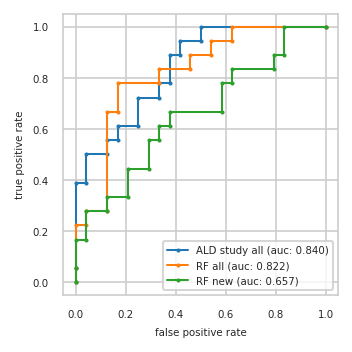

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.389  0.000 0.222  0.000 0.167
3          0.042 0.389  0.042 0.222  0.042 0.167
4          0.042 0.500  0.042 0.278  0.042 0.278
5          0.125 0.500  0.125 0.278  0.125 0.278
6          0.125 0.556  0.125 0.667  0.125 0.333
7          0.167 0.556  0.167 0.667  0.208 0.333
8          0.167 0.611  0.167 0.778  0.208 0.444
9          0.250 0.611  0.333 0.778  0.292 0.444
10         0.250 0.722  0.333 0.833  0.292 0.556
11         0.333 0.722  0.458 0.833  0.333 0.556
12         0.333 0.778  0.458 0.889  0.333 0.611
13         0.375 0.778  0.542 0.889  0.375 0.611
14         0.375 0.889  0.542 0.944  0.375 0.667
15         0.417 0.889  0.625 0.944  0.583 0.667
16         0.417 0.944  0.625 1.000  0.583 0.778
17         0.500 0.944  1.000 1.000  0.625 0.778
18         0.500 1.000    NaN   NaN  0.625 0.833
19         1.000 1.000    NaN   NaN  0.792 0.833
20           NaN   NaN    NaN   NaN  0.792 0.889
21           NaN   NaN    NaN   NaN  0.833 0.889
22           NaN   NaN    NaN   NaN  0.833 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,K7ER15;Q9H0R4;Q9H0R4-2,G3V295;G3V3I1;G3V5Z7;P60900
2,O76061,P02741,P51688
3,A0A0A0MRJ7;P12259,P04075,Q9NUQ9
4,P61981,P61981,P31321
5,P14174,P25189;P25189-2,Q96GD0
6,P04075,Q9Y2T3;Q9Y2T3-3,J3KSJ8;Q9UD71;Q9UD71-2
7,C9JF17;P05090,Q14894,A0A075B7B8
8,P00338;P00338-3,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


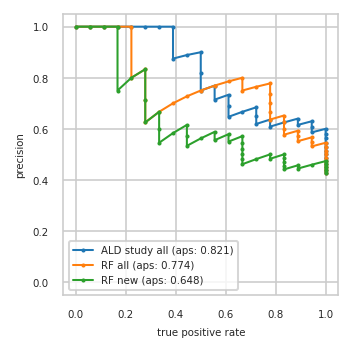

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.531 0.944     0.469 0.833
11         0.581 1.000     0.548 0.944     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.630 0.944     0.593 0.889     0.481 0.722
16         0.615 0.889     0.577 0.833     0.462 0.667
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.625 0.833     0.625 0.833     0.500 0.667
19         0.609 0.778     0.652 0.833     0.522 0.667
20         0.636 0.778     0.636 0.778     0.545 0.667
21         0.619 0.722     0.667 0.778     0.571 0.667
22         0.650 0.722     0.700 0.778     0.550 0.611
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.667 0.667     0.778 0.778     0.556 0.556
25         0.647 0.611     0.765 0.722     0.588 0.556
26         0.688 0.611     0.750 0.667     0.562 0.500
27         0.733 0.611     0.800 0.667     0.533 0.444
28         0.714 0.556     0.786 0.611     0.571 0.444
29         0.769 0.556     0.769 0.556     0.615 0.444
30         0.750 0.500     0.750 0.500     0.583 0.389
31         0.818 0.500     0.727 0.444     0.545 0.333
32         0.900 0.500     0.700 0.389     0.600 0.333
33         0.889 0.444     0.667 0.333     0.667 0.333
34         0.875 0.389     0.625 0.278     0.625 0.278
35         1.000 0.389     0.714 0.278     0.714 0.278
36         1.000 0.333     0.833 0.278     0.833 0.278
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


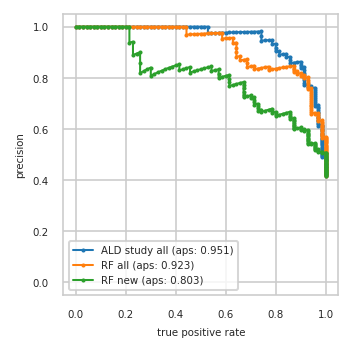

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


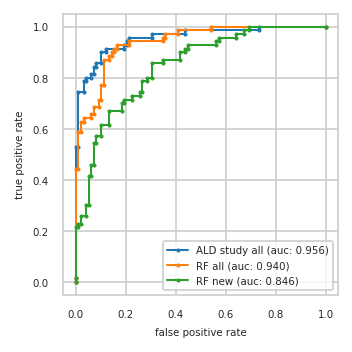

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}